In [264]:
# Imports
import numpy as np
import pandas as pd
import os 
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import folium
import json

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier


Read file for Arnesh

In [265]:
# listings_filepath = '/Users/arneshsaha/Desktop/AirBnb/datasets/listings.csv'
# listings_df = pd.read_csv(listings_filepath)

Read file for Abhay

In [266]:
listings_filepath = '/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/listings.csv'
listings_df = pd.read_csv(listings_filepath)

Data Cleaning

In [267]:
# Deleting Unnecessary Columns
columns = ['host_url', 'host_name', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'calendar_updated', 'calendar_last_scraped','picture_url', 'neighbourhood_group_cleansed','license', 'host_location', 'first_review', 'last_review', 'host_thumbnail_url', 'host_picture_url' ]
listings_df.drop(columns=columns, inplace=True)

# Converting columns with (True, False) to (1, 0)
replace_dict = {'instant_bookable':{'t':1, 'f':0}, 
                'host_identity_verified':{'t':1, 'f':0},
                'host_has_profile_pic':{'t':1, 'f':0},
                'host_is_superhost':{'t':1, 'f':0},
                'has_availability':{'t':1, 'f':0}
                }
listings_df = listings_df.replace(replace_dict)

# Removing HTML tags from description
def remove_html_tags(text):
    if pd.isna(text):
        return text
    soup = BeautifulSoup(text, 'html.parser')
    return soup.get_text()

listings_df['description'] = listings_df['description'].apply(remove_html_tags)

# Creating parking column and assigning the rows with parking feature
parking_rows = listings_df[(listings_df['name'].str.contains('parking', case=False)) | 
                           (listings_df['amenities'].apply(lambda x: 'parking' in x))]

listings_df['Parking'] = 0
listings_df.loc[parking_rows.index, 'Parking'] = 1

# Creating room_type_num column to store unique types in room_type
room_type_labels, room_type_unique = pd.factorize(listings_df['room_type'])
listings_df['room_type_num'] = room_type_labels
# ['Entire home/apt', 'Private room', 'Shared room', 'Hotel room']

# Removing % symbol 
listings_df['host_acceptance_rate'] = listings_df['host_acceptance_rate'].str.replace('%', '')
listings_df['host_response_rate'] = listings_df['host_response_rate'].str.replace('%', '')


listings_df.head()




/var/folders/g6/l9c_w0xj7zv_8_35j60mvnm80000gp/T/ipykernel_87251/3872489768.py:18: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


,id,name,description,neighborhood_overview,host_id,host_since,host_about,host_response_time,host_response_rate,host_acceptance_rate,...,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,Parking,room_type_num
0,15420,Georgian Boutique Apt City Centre,"Stunning, spacious ground floor apartment minu...","The neighbourhood is in the historic New Town,...",60423,2009-12-06,"I have a background in property, having worked...",within a few hours,100,96,...,4.98,4.91,0,1,1,0,0,3.10,1,0
1,707097,Centre Royal Mile Apartment 3 bedrooms 2 bathr...,NaN,"The location is the perfect for tourism , shor...",3092851,2012-07-29,Airbnb partner owner . Will do my best to make...,within a day,50,84,...,4.94,4.09,1,8,6,2,0,0.55,1,0
2,728199,"Private room in central, spacious and comfy flat",Fantastic main door flat over two levels withi...,"Great location for access to the city centre, ...",3776412,2012-10-06,We are an early/mid 40's couple who love to tr...,within an hour,100,95,...,4.73,4.79,0,1,0,1,0,2.86,1,1
3,732008,51 18 Caledonian Crescent,This beautiful third floor apartment is set in...,NaN,3810279,2012-10-09,We are a family run business specialising in h...,within an hour,100,99,...,4.71,4.70,1,2,2,0,0,2.27,1,0
4,744710,Refurbished Flat in a Georgian Era Building in...,A stunning apartment in the heart of Edinburgh...,The apartment is in a Central Edinburgh neighb...,3737047,2012-10-02,I'm Gareth and I own and manage this gem of a ...,within an hour,100,100,...,4.96,4.86,1,1,1,0,0,1.73,1,0


Abhay GeoJson File Path

In [268]:
path = '/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/neighbourhoods.geojson'

Arnesh GeoJSon File PAth 

In [269]:
# path = '/Users/arneshsaha/Desktop/AirBnb/datasets/neighbourhoods.geojson'

In [270]:

# read the .geojson file
with open(path) as f:
    data = json.load(f)

# create a folium map centered at a specific location
m = folium.Map(location=[55.9533, -3.1883], zoom_start=12)

folium.GeoJson(
    'https://raw.githubusercontent.com/johan/world.geo.json/master/countries/GBR.geo.json',
    name='geojson'
).add_to(m)

# add the data to the map as a GeoJSON layer
folium.GeoJson(data).add_to(m)

sample_df = listings_df.sample(n=50, random_state=42)
# Add markers for each point in the sampled DataFrame
for index, row in sample_df.iterrows():
    folium.Marker([row['latitude'], row['longitude']]).add_to(m)

# display the map in the Jupyter notebook
m


Question 1

In [271]:
# Deleting columns unnecessary for question1-
quality_df = listings_df
columns =['description', 'neighborhood_overview', 'host_since', 'host_about', 'host_neighbourhood', 'host_verifications', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'property_type', 'reviews_per_month']
quality_df.drop(columns=columns, inplace=True)
quality_df.dropna(subset=['host_response_time', 'amenities', 'bedrooms','review_scores_cleanliness', "beds","host_acceptance_rate", "bathrooms_text"], inplace=True)

# Convert variables from host_response_time to int into host_response_time_num column
host_response_time_labels, host_response_time_unique = pd.factorize(quality_df['host_response_time'])
quality_df['host_response_time_num'] = host_response_time_labels
# ['within a few hours', 'within a day', 'within an hour', 'a few days or more']

quality_df['host_response_rate'] = quality_df['host_response_rate'].astype(float)
quality_df['host_acceptance_rate'] = quality_df['host_acceptance_rate'].astype(float)

# Removing dollar sign from price
quality_df['price'] = quality_df['price'].str.replace(',', '',regex=True).str.replace('$', '',regex=True).astype('float')

# Extract the number from each entry in the 'bathrooms_text' column
quality_df['bathrooms_text'].fillna('0 baths', inplace=True)
quality_df['bathrooms'] = quality_df['bathrooms_text'].apply(lambda x: pd.to_numeric(pd.Series([x]).str.extract(r'(\d+\.?\d*)')[0], errors='coerce').fillna(0).astype('Float64'))
# Dropping 'bathrooms_text"
quality_df.drop(columns=['bathrooms_text'], inplace=True)

# Removing any row with Bathrooms = 0
quality_df = quality_df.drop(quality_df[quality_df['bathrooms'] == 0].index)

quality_df.info()

quality_df.to_csv('/Users/abhayrakeshdeshmukhmaurya/Library/CloudStorage/OneDrive-UniversityofEdinburgh/CS/University/Year 2/Data Science/CW3/AirBnb/datasets/quality_df.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5241 entries, 0 to 7387
Data columns (total 49 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5241 non-null   int64  
 1   name                                          5241 non-null   object 
 2   host_id                                       5241 non-null   int64  
 3   host_response_time                            5241 non-null   object 
 4   host_response_rate                            5241 non-null   float64
 5   host_acceptance_rate                          5241 non-null   float64
 6   host_is_superhost                             5241 non-null   float64
 7   host_listings_count                           5241 non-null   int64  
 8   host_total_listings_count                     5241 non-null   int64  
 9   host_has_profile_pic                          5241 non-null   i

Models
_________________________________

Text(0.5, 1.0, 'room_type_num vs price')

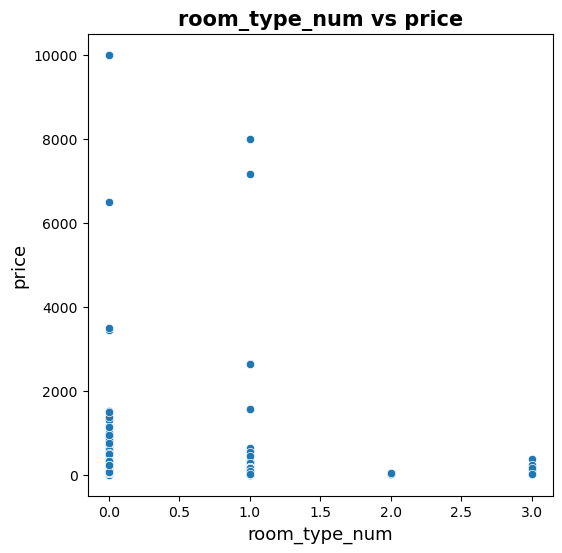

In [272]:
quality_df = quality_df.drop(quality_df[quality_df['price']>10000].index)


plt.figure(figsize=(6,6))
sns.scatterplot(x='room_type_num', y='price', data=quality_df)

plt.xlabel("room_type_num", size=13)
plt.ylabel("price", size=13)
plt.title("room_type_num vs price",size=15, weight='bold')

Text(0.5, 1.0, 'Price Distribution Plot')

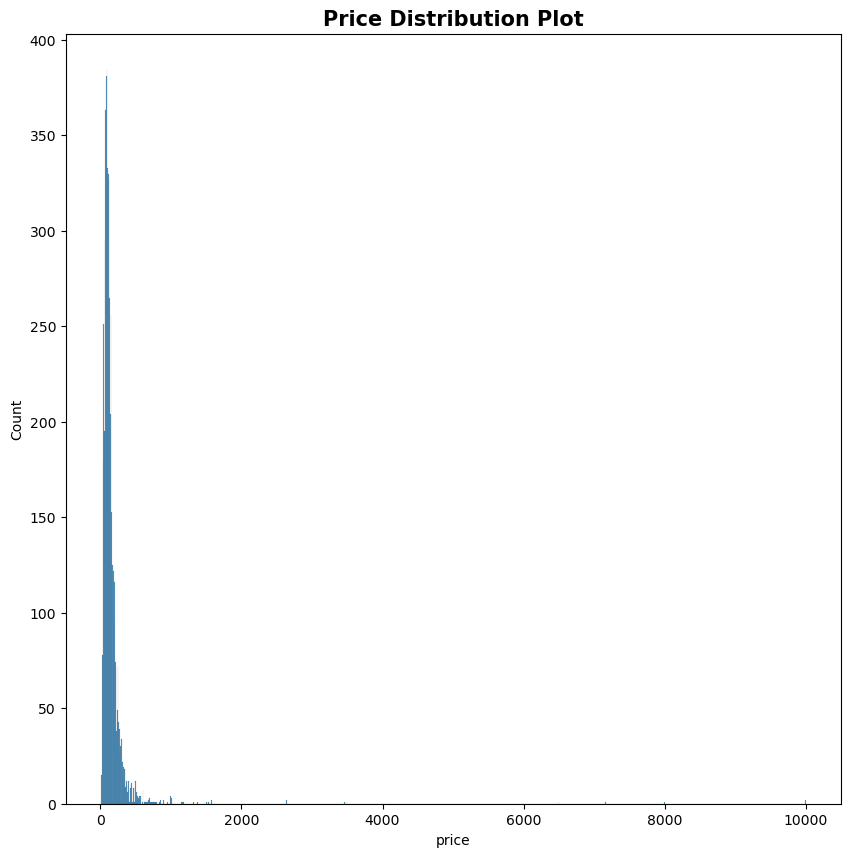

In [273]:
plt.figure(figsize=(10,10))
sns.histplot(quality_df['price'])
plt.title("Price Distribution Plot",size=15, weight='bold')

Text(0.5, 1.0, 'Log-Price Distribution Plot')

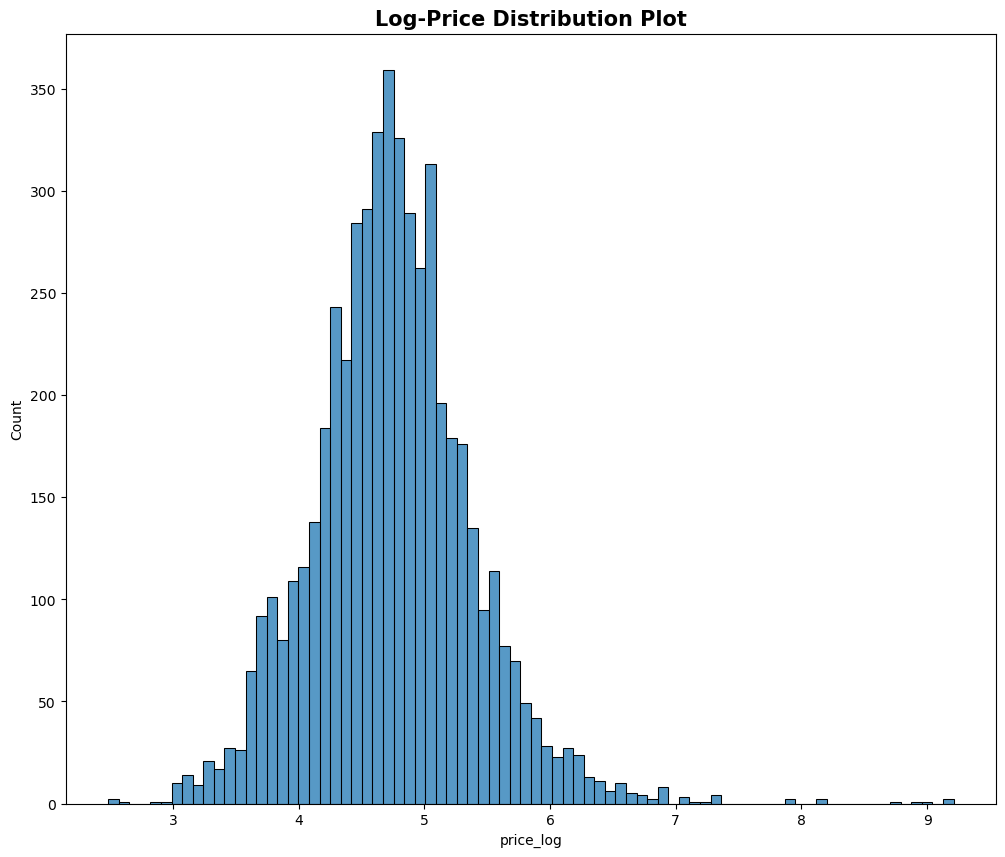

In [274]:
quality_df['price_log'] = np.log(quality_df.price + 1)

plt.figure(figsize=(12,10))
sns.histplot(quality_df['price_log'])
plt.title("Log-Price Distribution Plot",size=15, weight='bold')

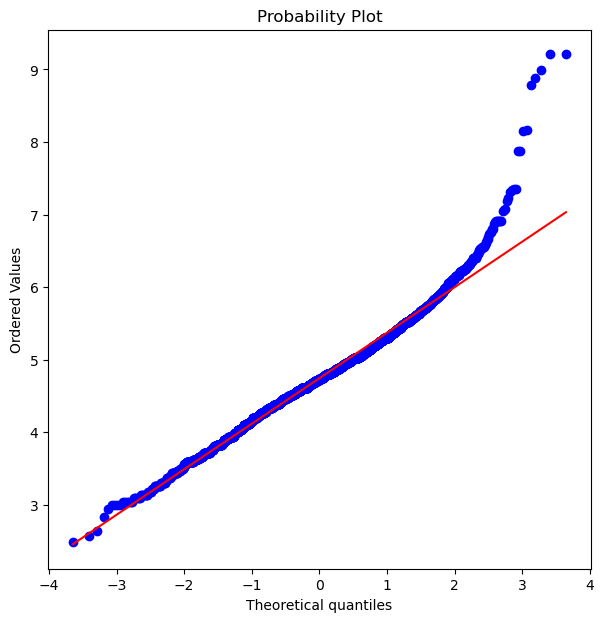

In [275]:
plt.figure(figsize=(7,7))
stats.probplot(quality_df['price_log'], plot=plt)
plt.show()

In [276]:
columns = ['name', 'host_response_time', 'neighbourhood_cleansed','amenities','host_id', ]
quality_df.drop(columns=columns, inplace=True)
quality_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5239 entries, 0 to 7387
Data columns (total 45 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            5239 non-null   int64  
 1   host_response_rate                            5239 non-null   float64
 2   host_acceptance_rate                          5239 non-null   float64
 3   host_is_superhost                             5239 non-null   float64
 4   host_listings_count                           5239 non-null   int64  
 5   host_total_listings_count                     5239 non-null   int64  
 6   host_has_profile_pic                          5239 non-null   int64  
 7   host_identity_verified                        5239 non-null   int64  
 8   accommodates                                  5239 non-null   int64  
 9   bathrooms                                     5239 non-null   f

In [277]:


quality_df_x, quality_df_y = quality_df.iloc[:,:-1], quality_df.iloc[:,-1]
quality_df_x = pd.DataFrame(quality_df_x, columns=quality_df.columns[:-1])


# scaler = StandardScaler()
# quality_df_x = scaler.fit_transform(quality_df_x)
# quality_df_x = pd.DataFrame(quality_df_x, columns=quality_df.columns[:-1])

In [278]:
# f, axes = plt.subplots(5, 2, figsize=(15, 20))
# sns.residplot(quality_df_x.iloc[:,0],quality_df_y, lowess=True, ax=axes[0, 0], 
#                           scatter_kws={'alpha': 0.5}, 
#                           line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})

Feature importances:

id: 0.0002885074085588589
host_response_rate: 8.865987610404271e-05
host_acceptance_rate: 1.2748784598686762e-05
host_is_superhost: 0.0034044992837873687
host_listings_count: 0.0022834850953198835
host_total_listings_count: 9.236981418988303e-05
host_has_profile_pic: 7.302403198106972e-11
host_identity_verified: 5.134812975597498e-09
accommodates: 0.005631232654828202
bathrooms: 0.0003770192603825118
bedrooms: 0.001148136817386807
beds: 0.0014892027607727998
minimum_nights: 0.00030149873246895537
maximum_nights: 0.0015890778260286356
minimum_minimum_nights: 0.00030919234663151496
maximum_minimum_nights: 0.00017688493608949423
minimum_maximum_nights: 0.00033580104243286055
maximum_maximum_nights: 0.0002372327211129979
minimum_nights_avg_ntm: 5.8140301850659074e-05
maximum_nights_avg_ntm: 0.0007665816503706893
has_availability: 6.81642901160622e-11
availability_30: 0.00021497245364585614
availability_60: 0.00029204504136165054
availability_90: 0.000311622535940388
a

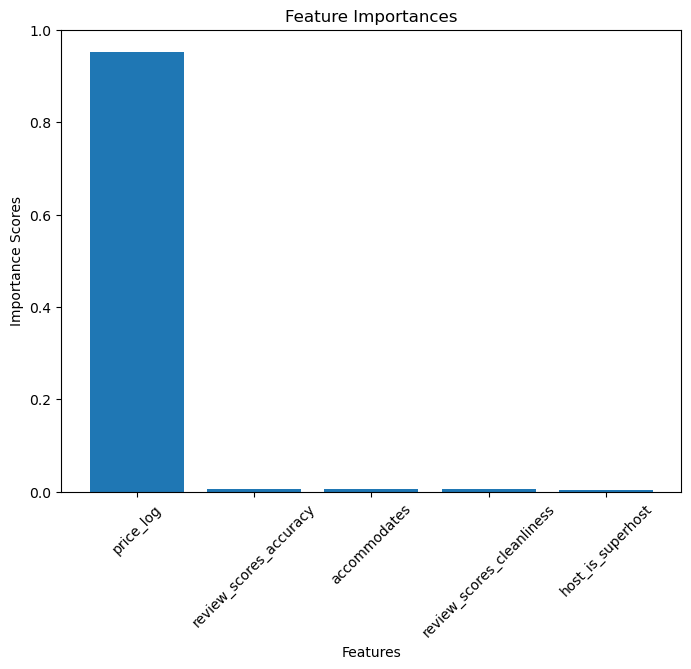

In [279]:
# Random Forest Prediction Feature
X_train, X_test, y_train, y_test = train_test_split(
quality_df.drop(columns=['price']), quality_df['price'], test_size=0.3, random_state=42)

# Create an instance of the RandomForestRegressor class
rf_reg = RandomForestRegressor(random_state=42)

# Train the model on the training set
rf_reg.fit(X_train, y_train)

# Get the feature importances
feature_importances = rf_reg.feature_importances_

# Print the feature importances
print("Feature importances:\n")
for feature, importance in zip(X_train.columns, feature_importances):
    print(f"{feature}: {importance}")

# Select the top k features with the highest importance scores
k = 5
top_k_features = X_train.columns[np.argsort(feature_importances)[::-1][:k]]
print(f"\nTop {k} features: {list(top_k_features)}")


# Plot the feature importances for the top k features
plt.figure(figsize=(8, 6))
plt.bar(top_k_features, feature_importances[np.argsort(feature_importances)[::-1][:k]])
plt.xticks(rotation=45)
plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importances')
plt.show()


In [280]:
### Linear Regression ###

def linear_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_LR= LinearRegression()

    parameters = {'fit_intercept':[True,False],  'copy_X':[True, False]}

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_LR = GridSearchCV(estimator=model_LR,  
                         param_grid=parameters,
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_LR.fit(input_x, input_y)
    best_parameters_LR = grid_search_LR.best_params_  
    best_score_LR = grid_search_LR.best_score_ 
    print(best_parameters_LR)
    print(best_score_LR)


linear_reg(quality_df_x, quality_df_y)

{'copy_X': True, 'fit_intercept': True}
-0.3036587532114634


In [281]:
### Ridge Regression ###

def ridge_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_Ridge= Ridge()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_Ridge = GridSearchCV(estimator=model_Ridge,  
                         param_grid=(dict(alpha=alphas)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_Ridge.fit(input_x, input_y)
    best_parameters_Ridge = grid_search_Ridge.best_params_  
    best_score_Ridge = grid_search_Ridge.best_score_ 
    print(best_parameters_Ridge)
    print(best_score_Ridge)
    
ridge_reg(quality_df_x, quality_df_y)

/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.41002e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=9.30232e-39): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=6.76956e-39): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.74322e-38): r

{'alpha': 1.0}
-0.16109340748947204


/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.12679e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.05039e-38): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [282]:
### Lasso Regression ###

def lasso_reg(input_x, input_y, cv=5):
    ## Defining parameters
    model_Lasso= Lasso()

    # prepare a range of alpha values to test
    alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
    normalizes= ([True,False])

    ## Building Grid Search algorithm with cross-validation and Mean Squared Error score.

    grid_search_lasso = GridSearchCV(estimator=model_Lasso,  
                         param_grid=(dict(alpha=alphas)),
                         scoring='neg_mean_squared_error',
                         cv=cv,
                         n_jobs=-1)

    ## Lastly, finding the best parameters.

    grid_search_lasso.fit(input_x, input_y)
    best_parameters_lasso = grid_search_lasso.best_params_  
    best_score_lasso = grid_search_lasso.best_score_ 
    print(best_parameters_lasso)
    print(best_score_lasso)

lasso_reg(quality_df_x, quality_df_y)

/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.220e+02, tolerance: 1.750e-01
  model = cd_fast.enet_coordinate_descent(
/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.725e+02, tolerance: 1.670e-01
  model = cd_fast.enet_coordinate_descent(
/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the

{'alpha': 0.001}
-0.14144750966707179


/Users/abhayrakeshdeshmukhmaurya/opt/anaconda3/envs/FDS/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.316e+02, tolerance: 2.112e-01
  model = cd_fast.enet_coordinate_descent(


In [283]:
kfold_cv=KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in kfold_cv.split(quality_df_x, quality_df_y):
    X_train, X_test = quality_df_x[train_index], quality_df_x[test_index]
    y_train, y_test = quality_df_y[train_index], quality_df_y[test_index]

KeyError: "None of [Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    9,   10,\n            ...\n            5223, 5224, 5226, 5228, 5229, 5231, 5235, 5236, 5237, 5238],\n           dtype='int64', length=4191)] are in the [columns]"

<Axes: >

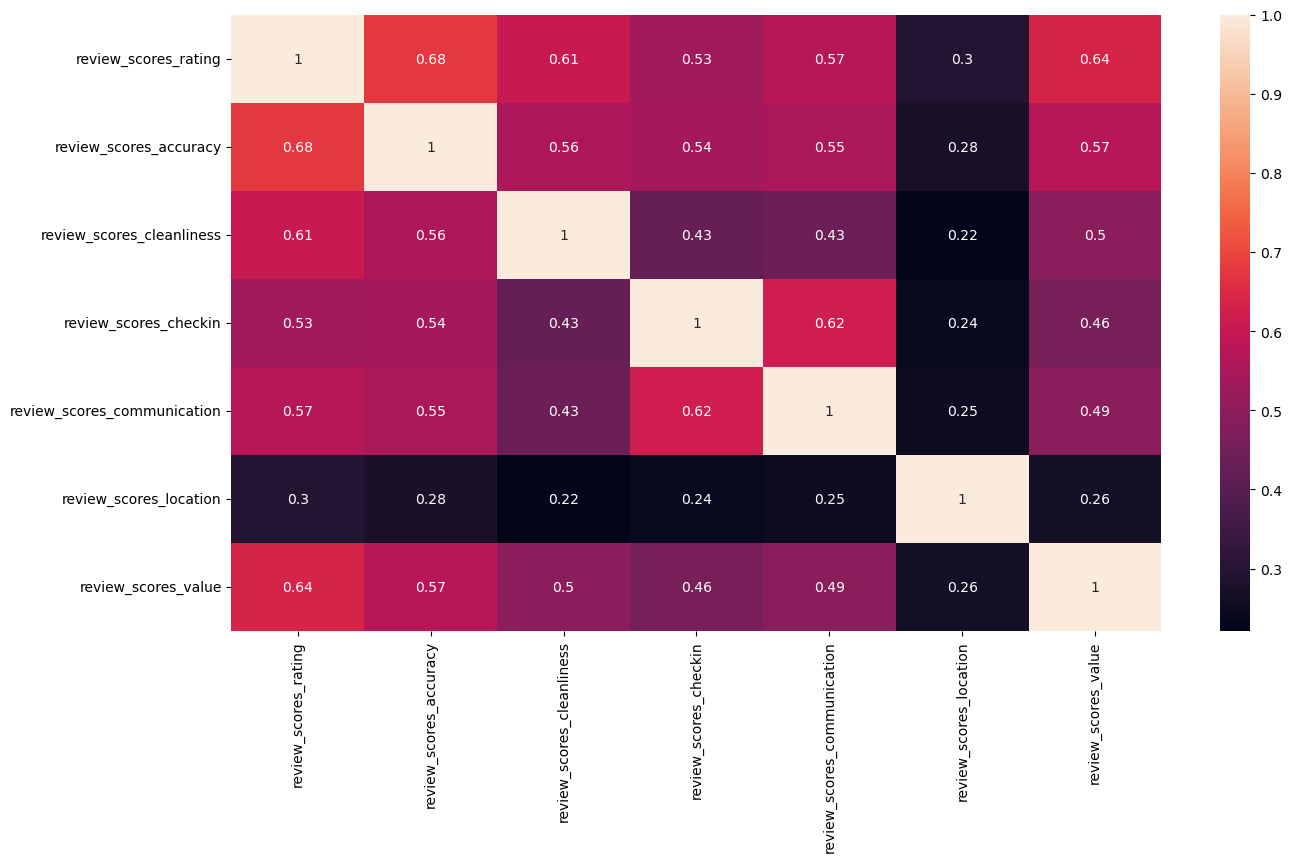

In [ ]:
col1 =['review_scores_accuracy','review_scores_rating', 'price','room_type_num', 'Parking','host_response_time_num', 'bedrooms','beds','bathrooms','availability_30']

reviewCol = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location',
        'review_scores_value']

corr = quality_df[reviewCol].corr(method='kendall')
plt.figure(figsize=(15,8))
sns.heatmap(corr, annot=True)

In [ ]:
# Choose the column you want to plot against all other columns
col_to_print = 'price'

# Calculate the correlation between the chosen column and all other columns
correlations = quality_df.corr()[col_to_print]

for col, corr in correlations.items():
    if col != col_to_print:
        print(f"Correlation between {col_to_print} and {col}: {corr:.2f}")

Correlation between price and host_response_rate: -0.02
Correlation between price and host_acceptance_rate: 0.02
Correlation between price and host_is_superhost: -0.01
Correlation between price and host_listings_count: 0.05
Correlation between price and host_total_listings_count: 0.04
Correlation between price and host_has_profile_pic: 0.01
Correlation between price and host_identity_verified: 0.03
Correlation between price and accommodates: 0.25
Correlation between price and bathrooms: 0.27
Correlation between price and bedrooms: 0.28
Correlation between price and beds: 0.20
Correlation between price and minimum_nights: 0.01
Correlation between price and maximum_nights: 0.01
Correlation between price and minimum_minimum_nights: 0.04
Correlation between price and maximum_minimum_nights: 0.02
Correlation between price and minimum_maximum_nights: -0.02
Correlation between price and maximum_maximum_nights: -0.01
Correlation between price and minimum_nights_avg_ntm: 0.02
Correlation betwee